In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms, models
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TRAIN_DIR = '../datasets/train'
VALID_DIR = '../datasets/val'
TEST_DIR = '../datasets/test'
save_path = '../output'

train_transform= transforms.Compose([
    transforms.Resize((224, 224)), # Require size by Resnet-18
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))
])

valid_transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))
])

In [3]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "test", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(TEST_DIR + image_name)
                    
        ### Apply Transforms on image
        img = self.transforms(img)

        return img
            
        
    def __len__(self):
        return len(self.imgs)

In [4]:
class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}
test_imgs = os.listdir(TEST_DIR)

# load the dataset
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)

classes = train_dataset.classes
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=valid_transform)

test_dataset = CatDogDataset(test_imgs, class_to_int, transforms=valid_transform)

train_size = len(train_dataset)
valid_size = len(valid_dataset)
# test_size  = len(test_dataset)

train_loader = DataLoader(
    train_dataset, batch_size=64,
    num_workers=4, pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset, batch_size=16,
    num_workers=4, pin_memory=True,
)

print(f"[INFO]: Number of training images: {train_size}")
print(f"[INFO]: Number of validation images: {valid_size}")
print(f"[INFO]: Class names: {classes}\n")

[INFO]: Number of training images: 20000
[INFO]: Number of validation images: 5000
[INFO]: Class names: ['cat', 'dog']



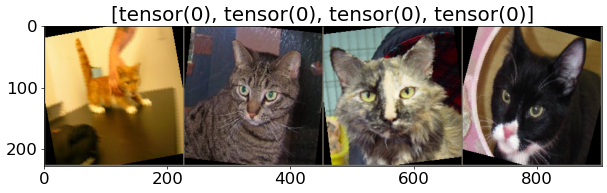

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_loader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = make_grid(inputs[:4])
imshow(out, title=[classes[x] for x in classes[:4]])

In [6]:
# use gpu or not
use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')

model = models.resnet18(pretrained=True)   #load resnet18 model
# num_features = model.fc.in_features     #extract fc layers features
# model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

if use_gpu:
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    model.to(torch.device('cuda'))
else:
    model.to(torch.device('cpu'))

criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

c:\Users\65913\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\65913\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
val_acc_history = []
# best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

def train(epoch, start_time):
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects / train_size * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

def val(epoch, start_time):
    """ Validation Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / valid_size
        epoch_acc = running_corrects / valid_size * 100.
        # if epoch_acc > best_acc:
        #     best_acc = epoch_acc
            # best_model_wts = copy.deepcopy(model.state_dict())
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))



In [8]:
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)

for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    train(epoch, start_time)
    val(epoch, start_time)

time_elapsed = time.time()- start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0 running
[Train #0] Loss: 0.8014 Acc: 94.6500% Time: 41.0064s
[Test #0] Loss: 28.3288 Acc: 50.0000% Time: 49.8649s
Epoch 1 running
[Train #1] Loss: 2.5049 Acc: 90.0950% Time: 85.1159s
[Test #1] Loss: 15.8647 Acc: 50.0000% Time: 93.9011s
Epoch 2 running


KeyboardInterrupt: 

In [ ]:
save_path = '../outputs/trained_model/custom-classifier_resnet_18_5epochs.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
from tqdm import tqdm

def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [ ]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified

In [ ]:
# Training the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 40

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)